In [ ]:
# The code in this file is meant to serve as examples that show some functionalities
# of the ADCS simulation framework. The same examples are also used in the documentation.
# At the end of this file, there is a full simulation example that uses real-time 
# plotting and can be useful for development.

# Change github link to profile

In [1]:
from spacecraft.satellite import SatelliteImplementation
from setup.initial_settings import SimulationSetupReader
from setup.two_line_element import TwoLineElementReader
from spacecraft.sensors import (
    MagnetometerImplementation,
    SunsensorImplementation,
    SensorFusionImplementation,
)
import core.transformations as tr
from pathlib import Path

setup = SimulationSetupReader(Path("setup/initial_settings.json"))
tle = TwoLineElementReader(Path("setup/tle"))
magnetometer = MagnetometerImplementation(setup)
sunsensor = SunsensorImplementation(setup)
sensor_fusion = SensorFusionImplementation(
    setup, ["triad", "quest", "ekf"], tr.euler_xyz_to_quaternion(setup.euler_angles)
)

satellite = SatelliteImplementation(setup, tle, magnetometer, sunsensor, sensor_fusion)

In [9]:
import core.utilities as ut

time_satellite = satellite.setup.date_time
satellite_julian_date = ut.time_julian_date(satellite)

print(f"Satellite time: {time_satellite}")
print(f"Satellite Julian date: {satellite_julian_date}")

Satellite time: 2025-10-22 17:30:10.008997
Satellite Julian date: <Time tt=2460818.709556771>


In [11]:
import skyfield.api as skyfield

satellite_model = skyfield.EarthSatellite(tle.line_1, tle.line_2)

julian_date = ut.time_julian_date(satellite)

position = satellite_model.at(julian_date).position.km
velocity = satellite_model.at(julian_date).velocity.km_per_s

print(f"Position vector: {position} [km]")
print(f"Velocity vector: {velocity} [km/s]")

Position vector: [-4107.48809952 -4489.58941621  3014.80595056] [km]
Velocity vector: [ 2.23875988 -5.3942253  -4.96501356] [km/s]


In [18]:
print(f"Two Line Element:\n{tle.line_1}{tle.line_2}")

print(f"Epoch Year: {tle.epoch_year}")
print(f"Epoch Day: {tle.epoch_day}")

print(f"Inclination: {tle.inclination}")
print(f"Bstar Drag: {tle.bstar_drag}")

Two Line Element:
1 25544U 98067A   25143.20875603  .00008836  00000-0  16445-3 0  9994
2 25544  51.6382  70.8210 0002488 135.0606  10.4960 15.49676890511280
Epoch Year: 25
Epoch Day: 143.20875603
Inclination: 51.6382
Bstar Drag:  16445-3


In [4]:
import pyIGRF
import core.utilities as ut
import datetime

# Satellite geodetic (deg, km)
lat = satellite.latitude
lon = satellite.longitude
alt_km = satellite.altitude
julian_date = ut.time_julian_date(satellite)

# Skyfield Time -> decimal year for IGRF
dt = julian_date.utc_datetime()
start = datetime.datetime(dt.year, 1, 1, tzinfo=dt.tzinfo)
end = datetime.datetime(dt.year + 1, 1, 1, tzinfo=dt.tzinfo)
decimal_year = dt.year + (dt - start).total_seconds() / (end - start).total_seconds()

# IGRF returns NED components in nT
d, i, h, b_n, b_e, b_d, f = pyIGRF.igrf_value(lat, lon, alt_km, decimal_year)

print(f"IGRF Magnetic Field NED: B_n={b_n:.2f}, B_e={b_e:.2f}, B_d={b_d:.2f} [nT]")
print(f"IGRF Magnetic Field Magnitude: F={f:.2f} [nT]")
print(
    f"IGRF Declination: D={d:.2f} [deg], Inclination: I={i:.2f} [deg], Horizontal Intensity: H={h:.2f} [nT]"
)

IGRF Magnetic Field NED: B_n=20470.13, B_e=-760.77, B_d=29507.77 [nT]
IGRF Magnetic Field Magnitude: F=35920.94 [nT]
IGRF Declination: D=-2.13 [deg], Inclination: I=55.23 [deg], Horizontal Intensity: H=20484.26 [nT]


In [5]:
import skyfield.api as skyfield
import core.utilities as ut

# load ephemeris data for sun and earth
eph = skyfield.load("de421.bsp")
sun = eph["sun"]
earth = eph["earth"]

julian_date = ut.time_julian_date(satellite)

sun_position_eci = earth.at(julian_date).observe(sun).position.km

print(f"Sun Position ECI: {sun_position_eci} [km]")

Sun Position ECI: [7.11550861e+07 1.22678186e+08 5.31785009e+07] [km]


In [1]:
import scipy.spatial.transform as R

euler_angles_init = [90.0, 0.0, 0.0]  # degrees
quaternion_init = [
    0.70710678,
    0.0,
    0.0,
    0.70710678,
]  # same rotation, where q[0:2] = vector part, q[3] = scalar part

reproduced_quaternion = R.Rotation.from_euler(
    "xyz", euler_angles_init, degrees=True
).as_quat()
reproduced_euler_angles = R.Rotation.from_quat(quaternion_init).as_euler(
    "xyz", degrees=True
)

print(f"Initial Euler Angles: {euler_angles_init} [deg]")
print(f"Initial Quaternion: {quaternion_init} [x, y, z, w]")
print(f"Reproduced Quaternion from Euler Angles: {reproduced_quaternion} [x, y, z, w]")
print(f"Reproduced Euler Angles from Quaternion: {reproduced_euler_angles} [deg]")

v1 = [0.0, 1.0, 0.0]

rotation = R.Rotation.from_quat(quaternion_init)
v2 = rotation.apply(v1)

print(f"Original Vector: {v1}")
print(f"Rotated Vector: {v2}")

Initial Euler Angles: [90.0, 0.0, 0.0] [deg]
Initial Quaternion: [0.70710678, 0.0, 0.0, 0.70710678] [x, y, z, w]
Reproduced Quaternion from Euler Angles: [0.70710678 0.         0.         0.70710678] [x, y, z, w]
Reproduced Euler Angles from Quaternion: [90.  0.  0.] [deg]
Original Vector: [0.0, 1.0, 0.0]
Rotated Vector: [0. 0. 1.]


In [ ]:
import core.transformations as tr
import core.utilities as ut

v1 = [0.0, 1.0, 0.0]
julian_date = ut.time_julian_date(satellite)
quaternion_init = [0.70710678, 0.0, 0.0, 0.70710678]

enu_ecef = tr.enu_to_ecef(v1, satellite.latitude, satellite.longitude)
ned_ecef = tr.ned_to_ecef(v1, satellite.latitude, satellite.longitude)
ecef_eci = tr.ecef_to_eci(v1, julian_date)
eci_sb = tr.eci_to_sb(v1, quaternion_init)
sb_eci = tr.sb_to_eci(v1, quaternion_init)

print(f"Original Vector: {v1}")
print(f"ENU to ECEF: {enu_ecef}")
print(f"NED to ECEF: {ned_ecef}")
print(f"ECEF to ECI: {ecef_eci}")
print(f"ECI to SB: {eci_sb}")
print(f"SB to ECI: {sb_eci}")

Original Vector: [0.0, 1.0, 0.0]
ENU to ECEF: [ 0.02791803  0.44449952 -0.89534393]
NED to ECEF: [ 0.99961022 -0.01241439  0.02500598]
ECEF to ECI: [0.69189531 0.72199784 0.        ]
ECI to SBF: [0. 0. 1.]
SBF to ECI: [ 0.  0. -1.]


In [ ]:
import numpy as np

# two reference vectors
v1_i = np.array([1.0, 0.0, 0.0])
v2_i = np.array([0.70710678, 0.70710678, 0.0])

# two measured vectors with some noise rotated by 90 deg around z axis
v1_b = np.array([0.0, 1.0, 0.0]) + np.random.uniform(-0.02, 0.02, size=3)
v2_b = np.array([-0.70710678, 0.70710678, 0.0]) + np.random.uniform(-0.05, 0.05, size=3)

q_reference = np.array([0.0, 0.0, 0.70710678, 0.70710678])

# typically the first vector should be the most accurate one
v_i_list = [v1_i, v2_i]
v_b_list = [v1_b, v2_b]

q_triad = sensor_fusion.triad(v_b_list, v_i_list)
q_quest = sensor_fusion.quest(v_b_list, v_i_list)
w_meas = np.deg2rad(
    np.array(setup.gyroscope["Bias"], dtype=float)
)  # zero true rate + bias
q_ekf = sensor_fusion.ekf(v_b_list, v_i_list, w_meas, 1.0, q_reference)

# signs may differ between algorithms, but represent the same rotation q = -q
print(f" Reference quaternion: {q_reference} [x, y, z, w]")
print(f" TRIAD Quaternion: {q_triad} [x, y, z, w]")
print(f" QUEST Quaternion: {q_quest} [x, y, z, w]")
print(f" EKF Quaternion: {q_ekf} [x, y, z, w]")

 Reference quaternion: [0.         0.         0.70710678 0.70710678] [x, y, z, w]
 TRIAD Quaternion: [-0.01693025 -0.01254686  0.7105929   0.70328776] [x, y, z, w]
 QUEST Quaternion: [-0.01691007 -0.01257405  0.70946175  0.70442883] [x, y, z, w]
 EKF Quaternion: [-0.00855144 -0.00616122  0.70900606  0.70512362] [x, y, z, w]


In [3]:
print(satellite.angular_velocity)
print(satellite.inertia_matrix)
print(satellite.magnetic_field)
print(satellite.torque)

[  8. -14.  11.]
[[0.002 0.    0.   ]
 [0.    0.002 0.   ]
 [0.    0.    0.002]]
(array([-12117.938582  , -12371.50694404, -31464.45657624]), array([-12121.11401262, -12375.32291477, -31468.13563725]))
[0. 0. 0.]


In [10]:
# satellite.state_vector.reset()  # without reset it would accumulate data from previous tests
satellite.state_vector.next_row()  # initialization and iterating row index

satellite._state_vector.register_vector("angular_velocity", satellite.angular_velocity, labels=["x", "y", "z"])
satellite._state_vector.register_value("latitude", satellite.latitude)
# comment out satellite.state_vector.reset() and uncomment the line below to test accumulation
# when some value is not present from the beginning
satellite._state_vector.register_value("pointing_error", satellite.pointing_error_angle)

print(satellite._state_vector.to_dataframe())

   angular_velocity_x  angular_velocity_y  angular_velocity_z  latitude  \
0                 2.0                -3.0                 4.0  26.40241   
1                 2.0                -3.0                 4.0  26.40241   
2                 2.0                -3.0                 4.0  26.40241   
3                 2.0                -3.0                 4.0  26.40241   
4                 2.0                -3.0                 4.0  26.40241   

   pointing_error  
0             NaN  
1             NaN  
2             NaN  
3             0.0  
4             0.0  


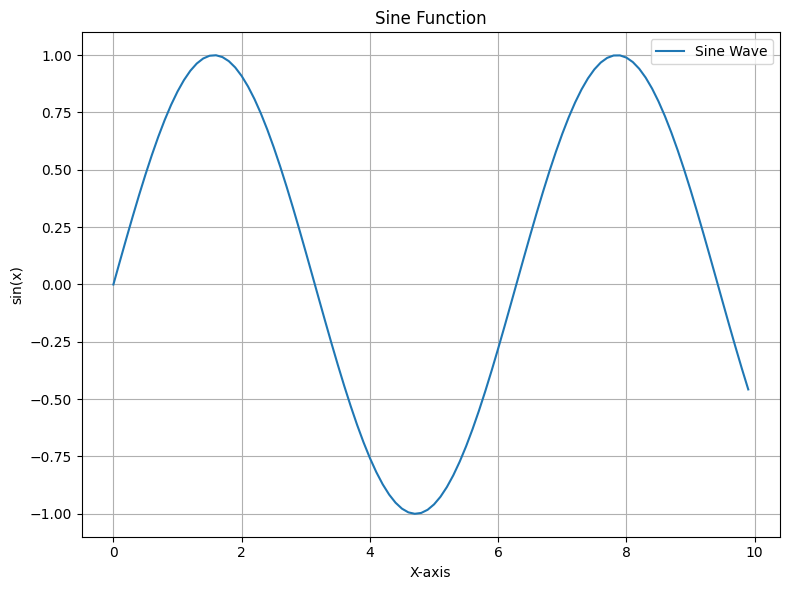

In [ ]:
from visualizations.visualizations import MatplotlibPlots
from visualizations.visualizations import PlotlyPlots
import numpy as np

x = np.arange(0, 10, 0.1)
y = np.sin(x)

mpl = MatplotlibPlots(save=False, show=True)
pp = PlotlyPlots(save=False, show=True)

mpl.line_plot({"Sine Wave": (x, y)}, "Sine Function", "X-axis", "sin(x)", "sine_wave_matplotlib")
pp.line_plot({"Sine Wave": (x, y)}, "Sine Function", "X-axis", "sin(x)", "sine_wave_plotly")

In [ ]:
# A full simulation written as notebook cell with real time plotting for rather develoment use

from spacecraft.satellite import SatelliteImplementation
from setup.initial_settings import SimulationSetupReader
from setup.two_line_element import TwoLineElementReader
from visualizations.visualizations import MatplotlibPlots
from visualizations.visualizations import PlotlyPlots
from spacecraft.sensors import MagnetometerImplementation, SunsensorImplementation, SensorFusionImplementation
import core.transformations as tr
import core.utilities as ut
from pathlib import Path
from visualizations.visualizations import LivePlotlyLine
import numpy as np
from core.logger import log


# Live angular velocity chart
live_w = LivePlotlyLine(
    labels=["wx", "wy", "wz", "|w|"],
    title="Angular velocity (live)",
    xlabel="Time (s)",
    ylabel="deg/s",
    window=1000,          # rolling window in 'Time (s)' units
)

setup = SimulationSetupReader(Path('setup/initial_settings.json'))
tle = TwoLineElementReader(Path('setup/tle'))
magnetometer = MagnetometerImplementation(setup)
sunsensor = SunsensorImplementation(setup)
sensor_fusion = SensorFusionImplementation(setup, ['triad', 'quest', 'ekf'], tr.euler_xyz_to_quaternion(setup.euler_angles))

satellite = SatelliteImplementation(setup, tle, magnetometer, sunsensor, sensor_fusion)
quaternion_prev = satellite.quaternion.copy()

satellite.state_vector.reset()
satellite.state_vector.next_row()
ut.basic_state_vector(satellite)
ut.log_init_state(setup)

n_iter = setup.iterations_info["Stop"]
for x in range(setup.iterations_info["Start"], n_iter, setup.iterations_info["Step"]):
    satellite.manage_actuators_sensors_timing()
    satellite.update_iteration(x)
    satellite.apply_rotation()

    mag_field_sb, mag_field_eci = satellite.magnetic_field
    sun_vector_sb, sun_vector_eci = satellite.sun_vector

    if x % setup.iterations_info["LogInterval"] == 0:
        log(f"Iteration {x} of {n_iter}")

    satellite.fuse_sensors(
        [mag_field_sb, sun_vector_sb],
        [mag_field_eci, sun_vector_eci],
        quaternion_prev
    )
    
    satellite.manage_modes()
    satellite.apply_detumbling()
    satellite.apply_pointing()

    satellite.state_vector.next_row()
    ut.basic_state_vector(satellite)

    wx, wy, wz = map(float, satellite.angular_velocity)
    wmag = float(np.sqrt(wx*wx + wy*wy + wz*wz))
    live_w.update(float(x), [wx, wy, wz, wmag])

    quaternion_prev = satellite.quaternion.copy() 

satellite.state_vector.to_csv('state_vector.csv')
mpl = MatplotlibPlots()
# renderer="vscode" or "browser"
pp = PlotlyPlots(save=True, show=False)
df = satellite.state_vector.to_dataframe()
mpl.basic_plots(df, setup)
pp.basic_plots(df, setup)


FigureWidget({
    'data': [{'mode': 'lines', 'name': 'wx', 'type': 'scatter', 'uid': 'd467f1b7-365f-42d9-b623-a856e2799d01'},
             {'mode': 'lines', 'name': 'wy', 'type': 'scatter', 'uid': '55475e51-5ae4-48eb-9f61-f3b0b801d40c'},
             {'mode': 'lines', 'name': 'wz', 'type': 'scatter', 'uid': '322cb7cf-2dbb-487c-8972-b5efc2b48d43'},
             {'mode': 'lines', 'name': '|w|', 'type': 'scatter', 'uid': 'b16e18c4-22ce-4d28-b98d-6685f8b10a0a'}],
    'layout': {'template': '...',
               'title': {'text': 'Angular velocity (live)'},
               'xaxis': {'title': {'text': 'Time (s)'}},
               'yaxis': {'title': {'text': 'deg/s'}}}
})

2025-11-14 23:42:20 | INFO | Simulation initialized with the following parameters:
2025-11-14 23:42:20 | INFO | Number of iterations: 10000
2025-11-14 23:42:20 | INFO | Satellite mass: 1.2 kg
2025-11-14 23:42:20 | INFO | Satellite inertia: [[0.002 0.    0.   ]
 [0.    0.002 0.   ]
 [0.    0.    0.002]] kg*m^2
2025-11-14 23:42:20 | INFO | Initial angular velocity: [ 2. -3.  4.] deg/s
2025-11-14 23:42:20 | INFO | Initial attitude (Euler angles): [0. 0. 0.] deg
2025-11-14 23:42:20 | INFO | Selected sensor fusion algorithm: EKF
2025-11-14 23:42:20 | INFO | Magnetometer noise: 10.0 nT
2025-11-14 23:42:20 | INFO | Sunsensor noise: 0.2 degrees
2025-11-14 23:42:20 | INFO | Sensor on time: 2 seconds, actuator on time: 8 seconds 

2025-11-14 23:42:20 | INFO | Iteration 0 of 10000
2025-11-14 23:42:25 | INFO | Iteration 100 of 10000
